<a href="https://colab.research.google.com/github/sandipanbasu/aiml-capstone/blob/master/Mrc_Eda_Squad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U tensorflow==2.0

## 1. Import Libraries, setting Google Drive

In [3]:
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import json
import pandas as pd
from pandas.io.json import json_normalize
from pprint import pprint
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
import re
import unicodedata
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

from nltk.util import bigrams
from nltk.util import ngrams
from nltk.probability import FreqDist

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

## 1 Loading Squad data - output of preprocessing step

In [5]:
project_path = "/content/drive/My Drive/AIML-MRC-Capstone/datasets/Squad2.0/TrainingDataset/"
#datafile = project_path+'train-v2.0.json'

In [6]:
datafile = project_path+'squad_data_final.csv'

In [7]:
squad_df = pd.read_csv(datafile)
squad_df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
squad_df.head(n=100)

,title,context,question,id,answer_start,answer,plausible_answer_start,plausible_answer,is_impossible,clean_context,clean_question,clean_answer,answer_len,answer_end,answer_span,answer_word_span
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,269,in the late 1990s,NaN,NaN,False,beyonc giselle knowles carter bi j nse bee yon...,when did beyonce start becoming popular,in the late 1990s,17,286,"(269, 286)","(44, 47)"
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,56be85543aeaaa14008c9065,207,singing and dancing,NaN,NaN,False,beyonc giselle knowles carter bi j nse bee yon...,what areas did beyonce compete in when she was...,singing and dancing,19,226,"(207, 226)","(33, 35)"
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,56be85543aeaaa14008c9066,526,2003,NaN,NaN,False,beyonc giselle knowles carter bi j nse bee yon...,when did beyonce leave destiny is child and be...,2003,4,530,"(526, 530)","(93, 93)"
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,56bf6b0f3aeaaa14008c9601,166,"Houston, Texas",NaN,NaN,False,beyonc giselle knowles carter bi j nse bee yon...,in what city and state did beyonce grow up,houston texas,13,179,"(166, 179)","(27, 28)"
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,56bf6b0f3aeaaa14008c9602,276,late 1990s,NaN,NaN,False,beyonc giselle knowles carter bi j nse bee yon...,in which decade did beyonce become famous,late 1990s,10,286,"(276, 286)","(46, 47)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Beyoncé,LeToya Luckett and Roberson became unhappy wit...,Who replaced Luckett and Roberson in Destiny's...,56d462f82ccc5a1400d8311f,110,Farrah Franklin and Michelle Williams.,NaN,NaN,False,letoya luckett and roberson became unhappy wit...,who replaced luckett and roberson in destiny i...,farrah franklin and michelle williams,38,148,"(110, 148)","(18, 22)"
96,Beyoncé,LeToya Luckett and Roberson became unhappy wit...,Who was blamed for Luckett and Roberson leavin...,56d462f82ccc5a1400d83120,149,Beyoncé,NaN,NaN,False,letoya luckett and roberson became unhappy wit...,who was blamed for luckett and roberson leavin...,beyonc,6,155,"(149, 155)","(23, 23)"
97,Beyoncé,LeToya Luckett and Roberson became unhappy wit...,Who helped Beyoncé overcome her depression dur...,56d462f82ccc5a1400d83121,714,her mother,NaN,NaN,False,letoya luckett and roberson became unhappy wit...,who helped beyonc overcome her depression duri...,her mother,10,724,"(714, 724)","(118, 119)"
98,Beyoncé,LeToya Luckett and Roberson became unhappy wit...,Which newest member was removed from Destiny's...,56d462f82ccc5a1400d83123,110,Farrah Franklin,NaN,NaN,False,letoya luckett and roberson became unhappy wit...,which newest member was removed from destiny i...,farrah franklin,15,125,"(110, 125)","(18, 19)"


In [ ]:
squad_df.describe()

,answer_start,plausible_answer_start,answer_len,answer_end
count,130306.000000,43498.000000,130306.000000,130306.000000
mean,212.722476,315.999563,13.215270,225.937747
std,264.887374,266.898767,19.692875,271.178408
min,-1.000000,0.000000,0.000000,-1.000000
25%,-1.000000,101.000000,0.000000,-1.000000
50%,110.000000,261.000000,7.000000,130.000000
75%,357.000000,470.000000,17.000000,377.000000
max,3126.000000,3292.000000,236.000000,3135.000000


In [8]:
squad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130306 entries, 0 to 130305
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   title                   130306 non-null  object 
 1   context                 130306 non-null  object 
 2   question                130306 non-null  object 
 3   id                      130306 non-null  object 
 4   answer_start            130306 non-null  int64  
 5   answer                  86807 non-null   object 
 6   plausible_answer_start  43498 non-null   float64
 7   plausible_answer        43498 non-null   object 
 8   is_impossible           130306 non-null  bool   
 9   clean_context           130306 non-null  object 
 10  clean_question          130306 non-null  object 
 11  clean_answer            130306 non-null  object 
 12  answer_len              130306 non-null  int64  
 13  answer_end              130306 non-null  int64  
 14  answer_span         

## 2 Frequency Distribution of Answerable and Non-Answerable Questions

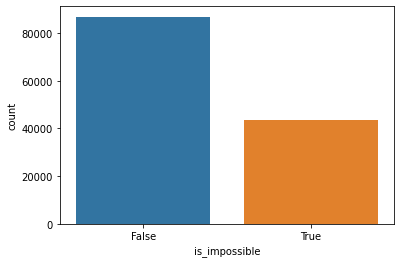

In [ ]:
sns.countplot(data = squad_df, x = "is_impossible")

## 3 Word Cloud of Questions

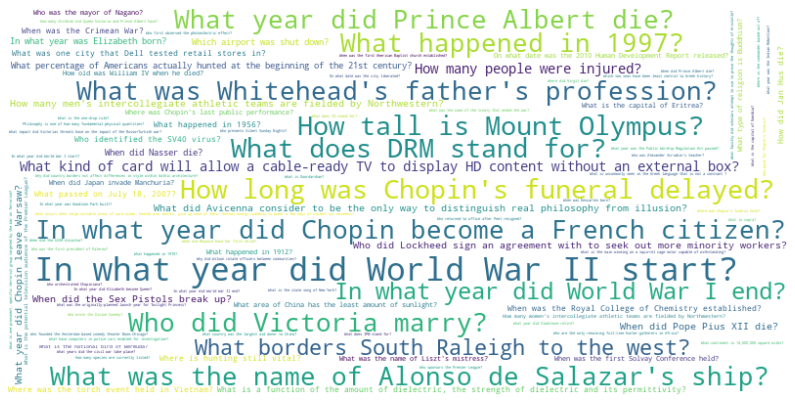

In [ ]:
text1 = dict(squad_df.question.value_counts())
wordcloud = WordCloud(width=800, height=400,background_color="white").generate_from_frequencies(text1)
plt.figure(figsize=[14,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 4 Calculating Average and Max Number of Words

### 4.1 Tokenizing clean_question, clean_answer and clean_context

In [ ]:

tokenized_word = squad_df['clean_question'].apply(word_tokenize)

pprint(tokenized_word)

0            [when, did, beyonce, start, becoming, popular]
1         [what, areas, did, beyonce, compete, in, when,...
2         [when, did, beyonce, leave, destiny, is, child...
3         [in, what, city, and, state, did, beyonce, gro...
4         [in, which, decade, did, beyonce, become, famous]
                                ...                        
130301    [physics, has, broadly, agreed, on, the, defin...
130302           [who, coined, the, term, partonic, matter]
130303         [what, is, another, name, for, anti, matter]
130304    [matter, usually, does, not, need, to, be, use...
130305    [what, field, of, study, has, a, variety, of, ...
Name: clean_question, Length: 130306, dtype: object


In [ ]:
tokenized_answer = squad_df['clean_answer'].apply(word_tokenize)

#pprint(tokenized_answer)

In [ ]:
tokenized_context = squad_df['clean_context'].apply(word_tokenize)

#pprint(tokenized_context)

### 4.2 Calculating total number of words in question, answer and context

In [ ]:
allWords_ques = []
for wordList in tokenized_word:
    allWords_ques += wordList

len(allWords_ques)    

1311408

In [ ]:
allWords_ans = []
for wordList in tokenized_answer:
    allWords_ans += wordList

len(allWords_ans)

330366

In [ ]:
allWords_context = []
for wordList in tokenized_context:
    allWords_context += wordList

len(allWords_context)

16000875

### 4.3 removing stop words from question, answer and context

In [ ]:
stop_words=set(stopwords.words("english"))
#stop_words

In [ ]:
#common stopwords in question
common_stopwords=[]
for w in allWords_ques:
    if w in stop_words:
      if w not in common_stopwords:           #to avoid duplicacy
        common_stopwords.append(w)
#print("Tokenized Sentence:",tokenized_sent)
print("Common Stopwords in question:",len(common_stopwords))
print(common_stopwords)

Common Stopwords in question: 134
['when', 'did', 'what', 'in', 'she', 'was', 'up', 'is', 'and', 'a', 'which', 'the', 'her', 'who', 'to', 'have', 'as', 'how', 'for', 'of', 'after', 'other', 'from', 'their', 'are', 'some', 'them', 'most', 'herself', 'has', 'under', 'own', 'won', 'with', 'where', 'i', 'at', 'his', 'on', 'through', 'during', 'its', 'be', 'over', 'it', 'out', 'by', 's', 'you', 'or', 'that', 'only', 'whom', 'am', 'more', 'than', 'any', 'should', 'now', 'they', 'this', 'about', 'had', 'an', 'before', 'again', 'were', 'both', 'if', 'do', 'so', 'why', 'does', 'these', 'will', 'between', 'until', 'but', 're', 'not', 'same', 'doing', 'all', 'there', 'can', 'because', 'no', 'been', 'off', 'he', 'while', 'being', 'into', 't', 'd', 'him', 'too', 'very', 'having', 'himself', 'once', 'down', 'each', 'few', 'm', 'against', 'themselves', 'those', 'here', 'then', 'above', 'shan', 'such', 'just', 'o', 'theirs', 'itself', 'our', 'further', 'don', 'my', 'me', 'we', 'yourself', 'y', 'below'

In [ ]:
stpwrds_ques = ['when', 'what', 'which', 'who', 'how', 'where', 'whom', 'why']

stopwords_noques = []

for w in common_stopwords:
    if w not in stpwrds_ques:           
        stopwords_noques.append(w)

print("Common Stopwords in question:",len(stopwords_noques))
print(stopwords_noques)

Common Stopwords in question: 126
['did', 'in', 'she', 'was', 'up', 'is', 'and', 'a', 'the', 'her', 'to', 'have', 'as', 'for', 'of', 'after', 'other', 'from', 'their', 'are', 'some', 'them', 'most', 'herself', 'has', 'under', 'own', 'won', 'with', 'i', 'at', 'his', 'on', 'through', 'during', 'its', 'be', 'over', 'it', 'out', 'by', 's', 'you', 'or', 'that', 'only', 'am', 'more', 'than', 'any', 'should', 'now', 'they', 'this', 'about', 'had', 'an', 'before', 'again', 'were', 'both', 'if', 'do', 'so', 'does', 'these', 'will', 'between', 'until', 'but', 're', 'not', 'same', 'doing', 'all', 'there', 'can', 'because', 'no', 'been', 'off', 'he', 'while', 'being', 'into', 't', 'd', 'him', 'too', 'very', 'having', 'himself', 'once', 'down', 'each', 'few', 'm', 'against', 'themselves', 'those', 'here', 'then', 'above', 'shan', 'such', 'just', 'o', 'theirs', 'itself', 'our', 'further', 'don', 'my', 'me', 'we', 'yourself', 'y', 'below', 'nor', 'your', 'ma', 'll', 'haven', 'ain', 'wouldn', 'doesn']

In [ ]:
# max num of words without stopwords in ques
allWords_nostopwords = []

for w in allWords_ques:
    if w not in stopwords_noques:           
        allWords_nostopwords.append(w)

print("allWords_nostopwords in question:",len(allWords_nostopwords))

allWords_nostopwords in question: 833663


In [ ]:
#common stopwords in answer
common_stopwords_ans=[]
for w in allWords_ans:
    if w in stop_words:
      if w not in common_stopwords_ans:           #to avoid duplicacy
        common_stopwords_ans.append(w)
#print("Tokenized Sentence:",tokenized_sent)
print("Common Stopwords in answer:",len(common_stopwords_ans))
print(common_stopwords_ans)

Common Stopwords in answer: 131
['in', 'the', 'and', 'is', 'her', 'my', 'of', 'no', 'with', 'a', 'i', 'it', 'out', 'd', 'at', 'for', 'during', 'by', 'on', 'but', 'up', 'to', 'more', 'than', 'most', 'same', 're', 'own', 'she', 'too', 'all', 'or', 'be', 'm', 'over', 'that', 'other', 'now', 'was', 'here', 's', 'his', 'y', 'few', 'an', 'from', 'will', 'me', 'being', 'as', 'them', 'between', 't', 'through', 'into', 'after', 'had', 'its', 'their', 'he', 'both', 'not', 'are', 'again', 'your', 'only', 'because', 'very', 'shan', 'about', 'why', 'each', 'have', 'did', 'those', 'this', 'has', 'when', 'were', 'any', 'o', 'against', 'which', 'itself', 'where', 'they', 'can', 'there', 'ma', 'so', 'down', 'while', 'off', 'then', 'do', 'before', 'don', 'what', 'him', 'who', 'how', 'some', 'nor', 'themselves', 'once', 'you', 'does', 'am', 'we', 'won', 'further', 'if', 'until', 'such', 'should', 'been', 'our', 'above', 'having', 'under', 'below', 'just', 'doing', 'these', 'whom', 'himself', 'yourself', 

In [ ]:
# max num of words without stopwords in ans
allWords_ans_nostopwords = []

for w in allWords_ans:
    if w not in common_stopwords_ans:           
        allWords_ans_nostopwords.append(w)

print("allWords_nostopwords in answer:",len(allWords_ans_nostopwords))

allWords_nostopwords in answer: 262677


In [ ]:
#common stopwords in context
common_stopwords_ctx=[]
#print(allWords_context[100])
for w in allWords_context:
    if w in stop_words:
      if w not in common_stopwords_ctx:           #to avoid duplicacy
        common_stopwords_ctx.append(w)
#print("Tokenized Sentence:",tokenized_sent)
print("Common Stopwords in context:",len(common_stopwords_ctx))
print(common_stopwords_ctx)

# there are no stop words in clean_context
print("max num of words without stopwords in context:",len(allWords_context))

Common Stopwords in context: 142
['is', 'an', 'and', 'in', 'she', 'as', 'a', 'to', 'the', 'of', 'by', 'her', 'all', 'their', 'which', 'd', 'into', 'with', 'i', 'am', 'for', 'on', 'it', 'from', 'over', 'was', 'its', 'that', 'are', 'have', 'has', 'further', 'won', 'most', 'during', 'while', 'through', 'where', 'when', 'after', 'at', 'they', 'were', 'other', 'them', 'his', 'not', 'up', 'before', 'only', 'be', 'this', 'under', 'no', 'or', 'some', 'such', 'my', 'more', 'than', 'being', 'so', 'herself', 'about', 'because', 'had', 'just', 'who', 's', 'out', 'whom', 'but', 'me', 'myself', 'both', 'then', 'you', 'same', 're', 'if', 'any', 'been', 'own', 'did', 'between', 'again', 'your', 'do', 'can', 'very', 'we', 'should', 'will', 'above', 'having', 'm', 'these', 'does', 'here', 'him', 'there', 'what', 'how', 'he', 'those', 'too', 'why', 'now', 'against', 't', 'o', 'himself', 'few', 'our', 'until', 'y', 'don', 'off', 'each', 'themselves', 'once', 'down', 'shan', 'itself', 'ourselves', 'below',

### 4.4 Calculating Avg words per ques, answer and context

In [ ]:
#Avg words/ ques
num_word_ques = len(allWords_nostopwords)
num_ques = len(squad_df.clean_question.value_counts())
print("num_word_ques: "+str(num_word_ques))
print(num_ques)
avg_words = num_word_ques/num_ques
print("avg_words: "+str(avg_words))

num_word_ques: 833663
130144
avg_words: 6.405696766658471


In [ ]:
#Avg words/ answer
num_word_ans = len(allWords_ans_nostopwords)
num_ans = len(squad_df.clean_answer.value_counts())
print("num_word_ques: "+str(num_word_ans))
print(num_ans)
avg_words_ans = num_word_ans/num_ans
print("avg_words: "+str(avg_words_ans))

num_word_ques: 262677
63738
avg_words: 4.1211992845712135


In [ ]:
#Avg words/ answer
num_word_ctx = len(allWords_context)
num_ctx = len(squad_df.clean_context.value_counts())
print("num_word_ctx: "+str(num_word_ctx))
print(num_ctx)
avg_words_ctx = num_word_ctx/num_ctx
print("avg_words: "+str(avg_words_ctx))

num_word_ctx: 16000875
19027
avg_words: 840.95627266516


### 4.5 Question answer and context length distribution

In [ ]:
ques_len = []
for line in squad_df['clean_question']:
        ques = len(line.split())
        ques_len.append(ques)

ans_len = []
for line in squad_df['clean_answer']:
        ans = len(line.split())
        ans_len.append(ans)

context_len = []
for line in squad_df['clean_context']:
        context = len(line.split())
        context_len.append(context)

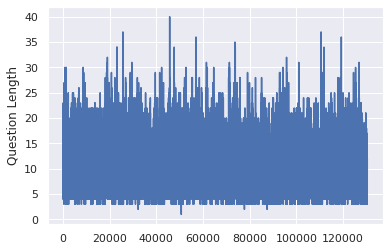

In [ ]:
plt.plot(ques_len)
plt.ylabel('Question Length')
plt.show()


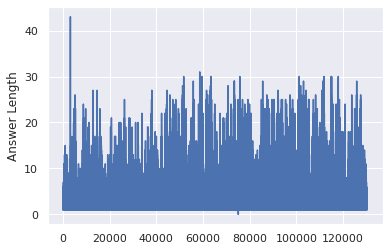

In [ ]:

plt.plot(ans_len)
plt.ylabel('Answer Length')
plt.show()

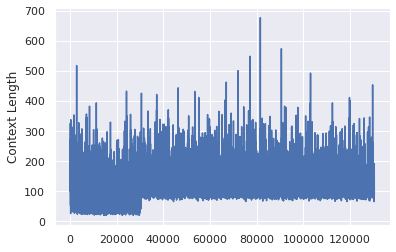

In [ ]:

plt.plot(context_len)
plt.ylabel('Context Length')
plt.show()

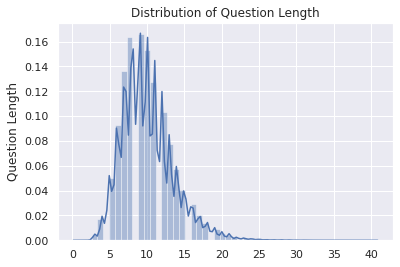

In [ ]:
sns.set(color_codes=True)
ax = sns.distplot(ques_len)
ax.set_title('Distribution of Question Length')
ax.set_ylabel('Question Length')
plt.savefig('question_length.png')
plt.show()

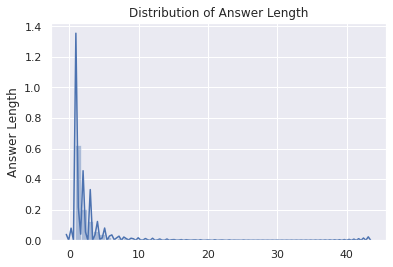

In [ ]:
sns.set(color_codes=True)
ax = sns.distplot(ans_len)
ax.set_title('Distribution of Answer Length')
ax.set_ylabel('Answer Length')
plt.savefig('answer_length.png')
plt.show()



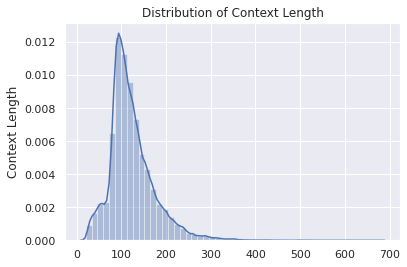

In [ ]:
sns.set(color_codes=True)
ax = sns.distplot(context_len)
ax.set_title('Distribution of Context Length')
ax.set_ylabel('Context Length')
plt.savefig('context_length.png')
plt.show()

In [ ]:
ques_array = np.array(ques_len)

print("Min:   ", np.min(ques_array))
print("Max:   ", np.max(ques_array))
print("Mean:   ", np.mean(ques_array))
print("25th percentile:   ", np.percentile(ques_array, 25))
print("Median:            ", np.median(ques_array))
print("75th percentile:   ", np.percentile(ques_array, 75))
print("95th percentile:   ", np.percentile(ques_array, 95))
print("99th percentile:   ", np.percentile(ques_array, 99))

Min:    1
Max:    40
Mean:    10.063335533283196
25th percentile:    8.0
Median:             10.0
75th percentile:    12.0
95th percentile:    16.0
99th percentile:    20.0


In [ ]:
 ans_array = np.array(ans_len)

print("Min:   ", np.min(ans_array))
print("Max:   ", np.max(ans_array))
print("Mean:   ", np.mean(ans_array))
print("25th percentile:   ", np.percentile(ans_array, 25))
print("Median:            ", np.median(ans_array))
print("75th percentile:   ", np.percentile(ans_array, 75))
print("95th percentile:   ", np.percentile(ans_array, 95))
print("99th percentile:   ", np.percentile(ans_array, 99))


Min:    0
Max:    43
Mean:    2.5350405967491905
25th percentile:    1.0
Median:             1.0
75th percentile:    3.0
95th percentile:    8.0
99th percentile:    17.0


In [ ]:
context_array = np.array(context_len)

print("Min:   ", np.min(context_array))
print("Max:   ", np.max(context_array))
print("Mean:   ", np.mean(context_array))
print("25th percentile:   ", np.percentile(context_array, 25))
print("Median:            ", np.median(context_array))
print("75th percentile:   ", np.percentile(context_array, 75))
print("95th percentile:   ", np.percentile(context_array, 95))
print("99th percentile:   ", np.percentile(context_array, 99))

Min:    20
Max:    677
Mean:    122.77821435697513
25th percentile:    91.0
Median:             113.0
75th percentile:    145.0
95th percentile:    217.0
99th percentile:    291.0


## 5 Calculating Unigrams, Bigrams and Frequency distribution

In [ ]:
def get_top_ngram(corpus, n=None):
     
    fdist = FreqDist(corpus)
    fdist_tup = fdist.most_common(20)
   
    return fdist_tup

In [ ]:
def get_top_bigram(corpus):
     
    bigrm = ngrams(corpus,2)
    fdist_bigram = FreqDist(list(bigrm))
    fdist_bigram_tup = fdist_bigram.most_common(20)
    #print(fdist_bigram_tup)

    return fdist_bigram_tup

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    #print(sum_words)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    #print(words_freq[:n])
    return words_freq[:n]


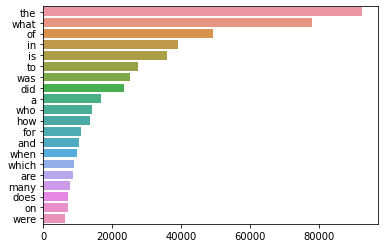

In [ ]:
unigrams_ques_all = get_top_ngram(allWords_ques,1)
x,y=map(list,zip(*unigrams_ques_all))
sns.barplot(x=y,y=x)

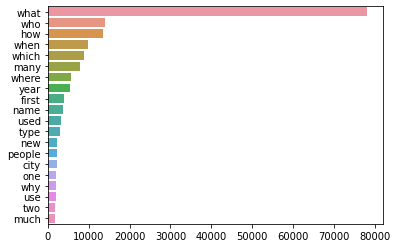

In [ ]:
unigrams_ques = get_top_ngram(allWords_nostopwords,1)
x1,y1=map(list,zip(*unigrams_ques))
sns.barplot(x=y1,y=x1)

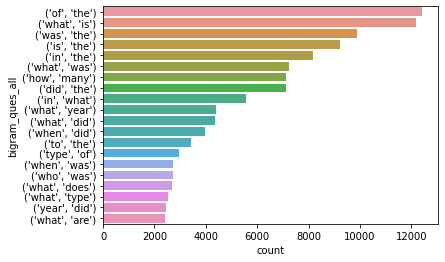

In [ ]:
bigrams_ques_all = get_top_bigram(allWords_ques)
df = pd.DataFrame(bigrams_ques_all, columns = ['bigram_ques_all' , 'count'])
df
sns.barplot(x=df['count'],y=df['bigram_ques_all'])

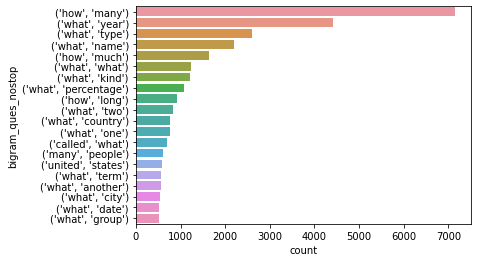

In [ ]:
#bigrams_ques = list(ngrams(allWords_nostopwords,2))
bigrams_ques_nostop = get_top_bigram(allWords_nostopwords)
df1 = pd.DataFrame(bigrams_ques_nostop, columns = ['bigram_ques_nostop' , 'count'])

sns.barplot(x=df1['count'],y=df1['bigram_ques_nostop'])

In [ ]:

print(len(bigrams_ques_all))
print(len(bigrams_ques_nostop))

1311407
833662


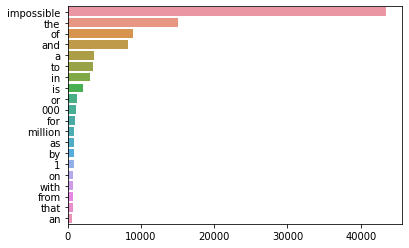

In [ ]:
unigrams_ans_all = get_top_ngram(allWords_ans,1)
x2,y2=map(list,zip(*unigrams_ans_all))
sns.barplot(x=y2,y=x2)

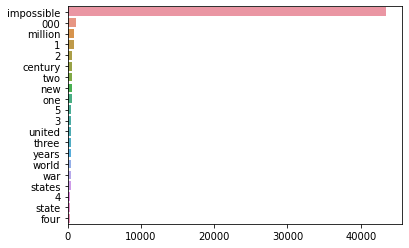

In [ ]:
unigrams_ans = get_top_ngram(allWords_ans_nostopwords,1)
x3,y3=map(list,zip(*unigrams_ans))
sns.barplot(x=y3,y=x3)

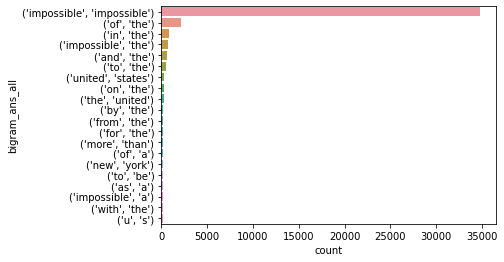

In [ ]:
#bigrams_ans_all = list(ngrams(allWords_ans,2))
bigrams_ans_all = get_top_bigram(allWords_ans)
df2 = pd.DataFrame(bigrams_ans_all, columns = ['bigram_ans_all' , 'count'])

sns.barplot(x=df2['count'],y=df2['bigram_ans_all'])

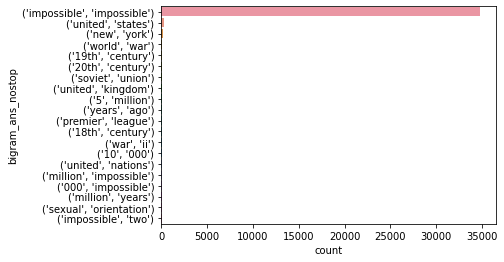

In [ ]:
#bigrams_ans = list(ngrams(allWords_ans_nostopwords,2))
bigrams_ans_nostop = get_top_bigram(allWords_ans_nostopwords)
df3 = pd.DataFrame(bigrams_ans_nostop, columns = ['bigram_ans_nostop' , 'count'])

sns.barplot(x=df3['count'],y=df3['bigram_ans_nostop'])

In [ ]:

print(len(bigrams_ans_all))
print(len(bigrams_ans))

330365
262676


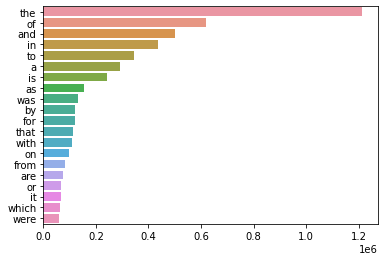

In [ ]:
unigrams_ctx = get_top_ngram(allWords_context,1)
x4,y4=map(list,zip(*unigrams_ctx))
sns.barplot(x=y4,y=x4)

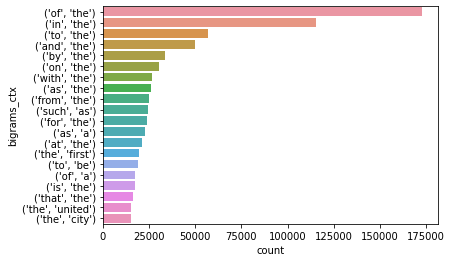

In [ ]:
#bigrams_ctx = list(ngrams(allWords_context,2))
bigrams_ctx = get_top_bigram(allWords_context)
df4 = pd.DataFrame(bigrams_ctx, columns = ['bigrams_ctx' , 'count'])

sns.barplot(x=df4['count'],y=df4['bigrams_ctx'])

In [ ]:
print(len(bigrams_ctx))

16000874


**Frequency Distribution**

In [ ]:
fdist_unigram_ques_all = FreqDist(unigrams_ques_all)
fdist_unigram_ques = FreqDist(unigrams_ques)
fdist_bigram_ques_all = FreqDist(bigrams_ques_all)
fdist_bigram_ques = FreqDist(bigrams_ques)

In [ ]:
fdist_unigram_ans_all = FreqDist(unigrams_ans_all)
fdist_unigram_ans = FreqDist(unigrams_ans)
fdist_bigram_ans_all = FreqDist(bigrams_ans_all)
fdist_bigram_ans = FreqDist(bigrams_ans)

In [ ]:
fdist_unigram_ctx = FreqDist(unigrams_ctx)
fdist_bigram_ctx = FreqDist(bigrams_ctx)

In [ ]:
import matplotlib.pyplot as plt


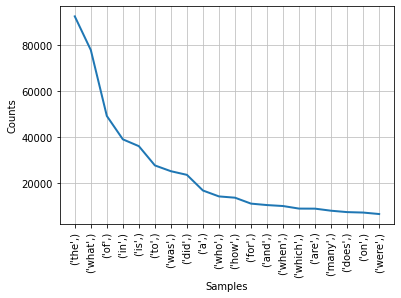

In [ ]:
fdist_unigram_ques_all.plot(20,cumulative=False)
plt.show()

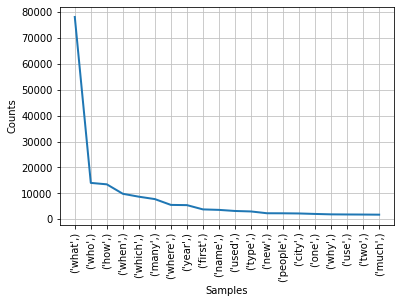

In [ ]:
fdist_unigram_ques.plot(20,cumulative=False)
plt.show()

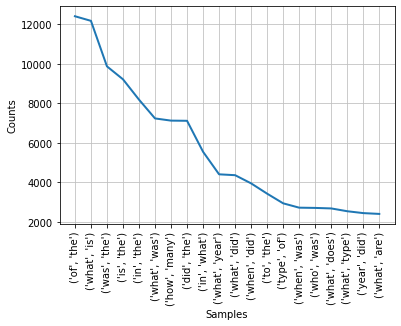

In [ ]:
fdist_bigram_ques_all.plot(20,cumulative=False)
plt.show()

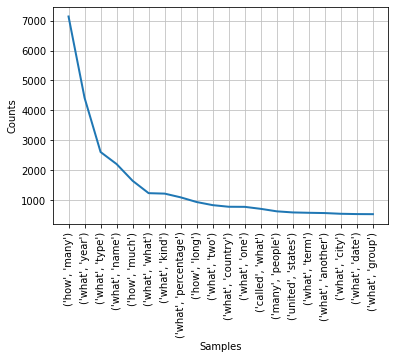

In [ ]:
fdist_bigram_ques.plot(20,cumulative=False)
plt.show()

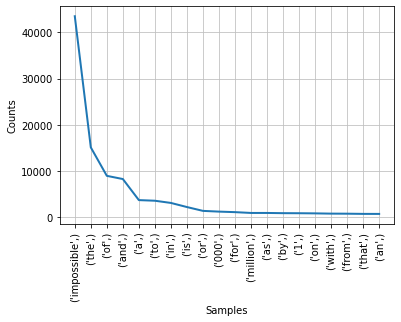

In [ ]:
fdist_unigram_ans_all.plot(20,cumulative=False)
plt.show()

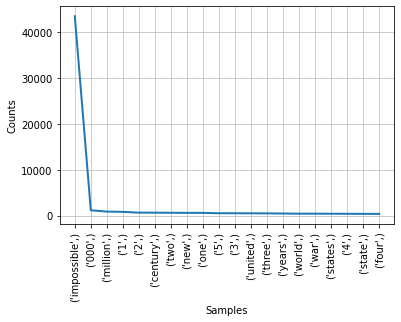

In [ ]:
fdist_unigram_ans.plot(20,cumulative=False)
plt.show()

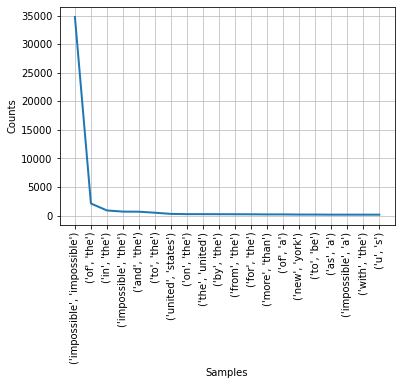

In [ ]:
fdist_bigram_ans_all.plot(20,cumulative=False)
plt.show()

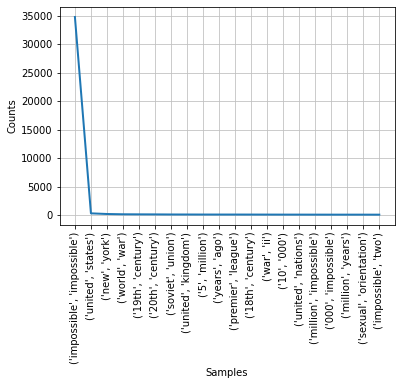

In [ ]:
fdist_bigram_ans.plot(20,cumulative=False)
plt.show()

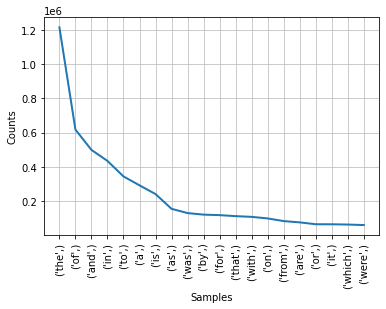

In [ ]:
fdist_unigram_ctx.plot(20,cumulative=False)
plt.show()


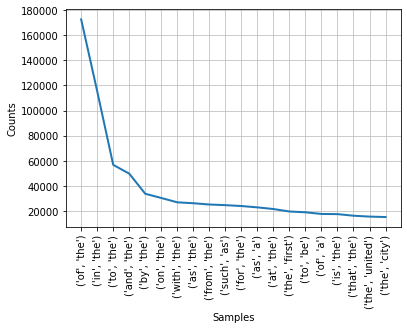

In [ ]:
fdist_bigram_ctx.plot(20,cumulative=False)
plt.show()

In [ ]:
fdist_unigram_ques_all.most_common(20)


[(('the',), 92688),
 (('what',), 77988),
 (('of',), 49188),
 (('in',), 38987),
 (('is',), 36008),
 (('to',), 27598),
 (('was',), 25070),
 (('did',), 23474),
 (('a',), 16640),
 (('who',), 14062),
 (('how',), 13506),
 (('for',), 10918),
 (('and',), 10284),
 (('when',), 9863),
 (('which',), 8743),
 (('are',), 8719),
 (('many',), 7816),
 (('does',), 7209),
 (('on',), 7015),
 (('were',), 6366)]

## 6 Question Category Distribution

**Categorizing Question**

In [ ]:
ques_df = pd.DataFrame(squad_df, columns = ['clean_question']) 


In [ ]:
ques_df['Token1'] = ques_df.clean_question.str.split(' ').str[0]

In [ ]:
ques_df['Token2'] = ques_df.clean_question.str.split(' ').str[1]

In [ ]:
ques_df.head(5)

,clean_question,Token1,Token2
0,when did beyonce start becoming popular,when,did
1,what areas did beyonce compete in when she was...,what,areas
2,when did beyonce leave destiny is child and be...,when,did
3,in what city and state did beyonce grow up,in,what
4,in which decade did beyonce become famous,in,which


In [12]:
stpwrds_ques = ['when', 'what', 'which', 'who', 'how', 'where', 'whom', 'why']

def get_categ(token1,token2):
    if token1 in stpwrds_ques:
        return token1
    elif token2 in stpwrds_ques:
        return token2
    else:
        return "Other"



In [ ]:
#stpwrds_ques = ['when', 'what', 'which', 'who', 'how', 'where', 'whom', 'why']
ques_df['Ques_category'] = ques_df.apply(lambda x: get_categ(x['Token1'],x['Token2']),axis=1)


In [ ]:
ques_df

,clean_question,Token1,Token2,Ques_category
0,when did beyonce start becoming popular,when,did,when
1,what areas did beyonce compete in when she was...,what,areas,what
2,when did beyonce leave destiny is child and be...,when,did,when
3,in what city and state did beyonce grow up,in,what,what
4,in which decade did beyonce become famous,in,which,which
...,...,...,...,...
130301,physics has broadly agreed on the definition o...,physics,has,Other
130302,who coined the term partonic matter,who,coined,who
130303,what is another name for anti matter,what,is,what
130304,matter usually does not need to be used in con...,matter,usually,Other


### 6.1 Question Category distribution Overall

In [ ]:
ques_df['Ques_category'].value_counts()

what     66255
Other    17691
who      12732
how      12056
when      7956
which     6714
where     4826
why       1868
whom       208
Name: Ques_category, dtype: int64

In [ ]:
ques_cat = ques_df['Ques_category'].value_counts(normalize=True)*100
ques_cat

what     50.845702
Other    13.576505
who       9.770847
how       9.252068
when      6.105628
which     5.152487
where     3.703590
why       1.433549
whom      0.159624
Name: Ques_category, dtype: float64

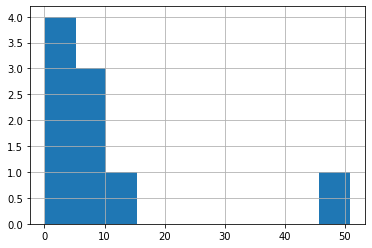

In [ ]:
(ques_df['Ques_category'].value_counts(normalize=True)*100).hist()

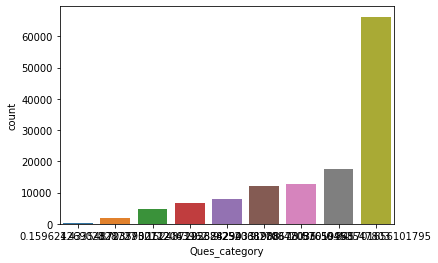

In [ ]:
sns.countplot(x=ques_df['Ques_category'], data=ques_cat)

In [ ]:
(ques_df['Ques_category']
.value_counts(normalize=True)
.mul(100)
.rename('percentage')
.reset_index()
.pipe((sns.catplot,'data'), x=ques_df['Ques_category'],y='percentage', kind='bar'))

### 6.2 Question Category Distribution for Non -answerable questions(is_impossible=True)

In [ ]:
#temp = squad_df.loc[squad_df['is_impossible'] == True]
ques_possible_true = pd.DataFrame(squad_df.loc[squad_df['is_impossible'] == True], columns = ['clean_question']) 
ques_possible_true.head(5)

,clean_question
2075,what category of game is legend of zelda austr...
2076,what consoles can be used to play australia tw...
2077,when was australia twilight launched in north ...
2078,when could gamecube owners purchase australian...
2079,what year was the legend of zelda australian p...


In [ ]:
ques_possible_true['Token1'] = ques_possible_true.clean_question.str.split(' ').str[0]
ques_possible_true['Token2'] = ques_possible_true.clean_question.str.split(' ').str[1]

In [ ]:
ques_possible_true['Ques_category'] = ques_possible_true.apply(lambda x: get_categ(x['Token1'],x['Token2']),axis=1)

In [ ]:
ques_possible_true

,clean_question,Token1,Token2,Ques_category
2075,what category of game is legend of zelda austr...,what,category,what
2076,what consoles can be used to play australia tw...,what,consoles,what
2077,when was australia twilight launched in north ...,when,was,when
2078,when could gamecube owners purchase australian...,when,could,when
2079,what year was the legend of zelda australian p...,what,year,what
...,...,...,...,...
130301,physics has broadly agreed on the definition o...,physics,has,Other
130302,who coined the term partonic matter,who,coined,who
130303,what is another name for anti matter,what,is,what
130304,matter usually does not need to be used in con...,matter,usually,Other


In [ ]:
ques_possible_true['Ques_category'].value_counts()

what     24319
who       4566
Other     4430
how       3661
when      2491
which     1851
where     1484
why        671
whom        25
Name: Ques_category, dtype: int64

In [ ]:
ques_possible_true['Ques_category'].value_counts(normalize=True)*100

what     55.908318
who      10.497034
Other    10.184376
how       8.416479
when      5.726700
which     4.255368
where     3.411651
why       1.542600
whom      0.057474
Name: Ques_category, dtype: float64

### 6.3 Question Category to Answer Length Cross tab ( drop questions which do not have answers- is_impossible=True)

In [ ]:
ques_ans_avg = pd.DataFrame(squad_df.loc[squad_df['is_impossible'] == False], columns = ['clean_question', 'clean_answer']) 
ques_ans_avg

,clean_question,clean_answer
0,when did beyonce start becoming popular,in the late 1990s
1,what areas did beyonce compete in when she was...,singing and dancing
2,when did beyonce leave destiny is child and be...,2003
3,in what city and state did beyonce grow up,houston texas
4,in which decade did beyonce become famous,late 1990s
...,...,...
130033,in what us state did kathmandu first establish...,oregon
130034,what was yangon previously known as,rangoon
130035,with what belorussian city does kathmandu have...,minsk
130036,in what year did kathmandu create its initial ...,1975


In [ ]:
def get_strlen(ans):
    return len(ans.split(' '))


In [ ]:
ques_ans_avg['ans_len'] = ques_ans_avg.apply(lambda x: get_strlen(x['clean_answer']),axis=1)

In [ ]:
ques_ans_avg['Token1'] = ques_ans_avg.clean_question.str.split(' ').str[0]
ques_ans_avg['Token2'] = ques_ans_avg.clean_question.str.split(' ').str[1]

In [ ]:
ques_ans_avg['Ques_category'] = ques_ans_avg.apply(lambda x: get_categ(x['Token1'],x['Token2']),axis=1)

In [ ]:
ques_ans_avg

,clean_question,clean_answer,ans_len,Token1,Token2,Ques_category
0,when did beyonce start becoming popular,in the late 1990s,4,when,did,when
1,what areas did beyonce compete in when she was...,singing and dancing,3,what,areas,what
2,when did beyonce leave destiny is child and be...,2003,1,when,did,when
3,in what city and state did beyonce grow up,houston texas,2,in,what,what
4,in which decade did beyonce become famous,late 1990s,2,in,which,which
...,...,...,...,...,...,...
130033,in what us state did kathmandu first establish...,oregon,1,in,what,what
130034,what was yangon previously known as,rangoon,1,what,was,what
130035,with what belorussian city does kathmandu have...,minsk,1,with,what,what
130036,in what year did kathmandu create its initial ...,1975,1,in,what,what


In [ ]:
category = ques_ans_avg.groupby('Ques_category')

In [ ]:
#pprint(category.groups)

In [ ]:
category['ans_len'].agg(np.mean)

Ques_category
Other    3.245381
how      3.376057
what     3.570512
when     2.436962
where    3.250449
which    2.774419
who      2.907666
whom     2.748634
why      8.202172
Name: ans_len, dtype: float64

### 6.4 Question Category to Question PoS Distribution

In [ ]:
ques_pos_dist = pd.DataFrame(squad_df, columns = ['question'])

In [ ]:
ques_pos_dist

,question
0,When did Beyonce start becoming popular?
1,What areas did Beyonce compete in when she was...
2,When did Beyonce leave Destiny's Child and bec...
3,In what city and state did Beyonce grow up?
4,In which decade did Beyonce become famous?
...,...
130301,Physics has broadly agreed on the definition o...
130302,Who coined the term partonic matter?
130303,What is another name for anti-matter?
130304,Matter usually does not need to be used in con...


In [9]:
stpwrds_ques = ['when', 'what', 'which', 'who', 'how', 'where', 'whom', 'why']
def get_categ(ques):
    len_ques = len(ques)
    if len_ques <= 2:
     print(ques)

    splt = ques.split(' ')

    tkn1 = splt[0]
    if len_ques <= 2:
     tkn2 = " "
    else:
      tkn2 = splt[1]

    if tkn1.lower() in stpwrds_ques:
        return tkn1.lower()
    elif tkn2.lower() in stpwrds_ques:
        return tkn2.lower()
    else:
        return "other"

In [ ]:
ques_pos_dist['Ques_category'] = ques_pos_dist.apply(lambda x: get_categ(x['question']),axis=1)

dd
d


In [ ]:
ques_pos_dist

,question,Ques_category
0,When did Beyonce start becoming popular?,when
1,What areas did Beyonce compete in when she was...,what
2,When did Beyonce leave Destiny's Child and bec...,when
3,In what city and state did Beyonce grow up?,what
4,In which decade did Beyonce become famous?,which
...,...,...
130301,Physics has broadly agreed on the definition o...,other
130302,Who coined the term partonic matter?,who
130303,What is another name for anti-matter?,what
130304,Matter usually does not need to be used in con...,other


In [17]:
adj_lst = ["JJ","JJR","JJS"]
nn_lst = ["NN","NNP","NNPS","NNS"]
vb_lst = ["VB","VBD","VBG","VBN","VBP","VBZ"]
num_lst = ["CD"]

def get_postags(ques):
  string = nltk.word_tokenize(ques)
  pos_tup = nltk.pos_tag(string)
  str_tgs = ""
  # Using map for 1 index 
  #c = map(lambda x: x[1], pos_tup)
  x,y=map(list,zip(*pos_tup))
  return y

In [ ]:
ques_pos_dist['Ques_pos']= ques_pos_dist.apply(lambda x: get_postags(x['question']),axis=1)

In [ ]:
ques_pos_dist

,question,Ques_category,Ques_pos
0,When did Beyonce start becoming popular?,when,"[WRB, VBD, NNP, VB, VBG, JJ, .]"
1,What areas did Beyonce compete in when she was...,what,"[WP, NNS, VBD, NNP, NN, IN, WRB, PRP, VBD, VBG..."
2,When did Beyonce leave Destiny's Child and bec...,when,"[WRB, VBD, NNP, VB, NNP, POS, NNP, CC, VB, DT,..."
3,In what city and state did Beyonce grow up?,what,"[IN, WP, NN, CC, NN, VBD, NNP, VB, RP, .]"
4,In which decade did Beyonce become famous?,which,"[IN, WDT, NN, VBD, NNP, VB, JJ, .]"
...,...,...,...
130301,Physics has broadly agreed on the definition o...,other,"[NNS, VBZ, RB, VBN, IN, DT, NN, IN, WP, .]"
130302,Who coined the term partonic matter?,who,"[WP, VBD, DT, NN, JJ, NN, .]"
130303,What is another name for anti-matter?,what,"[WP, VBZ, DT, NN, IN, NN, .]"
130304,Matter usually does not need to be used in con...,other,"[NNP, RB, VBZ, RB, VB, TO, VB, VBN, IN, NN, IN..."


In [ ]:
adj_lst = ["JJ","JJR","JJS"]
nn_lst = ["NN","NNP","NNPS","NNS"]
vb_lst = ["VB","VBD","VBG","VBN","VBP","VBZ"]
num_lst = ["CD"]

def getpos_count(pos_lst):
  #print("len: ",len(pos_lst))
  i=0
  adj_ctr = 0
  nn_ctr = 0
  vb_ctr = 0
  num_ctr = 0

  for i in range(len(pos_lst)):
    #str_tgs += y[i]+" "
    if pos_lst[i] in adj_lst:
     adj_ctr +=1
    if pos_lst[i] in nn_lst:
     nn_ctr +=1
    if pos_lst[i] in vb_lst:
     vb_ctr +=1
    if pos_lst[i] in num_lst:
     num_ctr +=1
  
  return pd.Series((adj_ctr, nn_ctr, vb_ctr, num_ctr))

In [ ]:
#print(ques_pos_dist.apply(lambda x: getpos_count(x['Ques_pos']),axis=1))
#zip(*df['num'].map(powers))
ques_pos_dist[['pos_adj', 'pos_nn', 'pos_vb', 'pos_num']] = ques_pos_dist.apply(lambda x: getpos_count(x['Ques_pos']),axis=1)
#ques_pos_dist['pos_adj'], ques_pos_dist['pos_nn'], ques_pos_dist['pos_vb'] = 

In [ ]:
ques_pos_dist

,question,Ques_category,Ques_pos,pos_adj,pos_nn,pos_vb,pos_num
0,When did Beyonce start becoming popular?,when,"[WRB, VBD, NNP, VB, VBG, JJ, .]",1,1,3,0
1,What areas did Beyonce compete in when she was...,what,"[WP, NNS, VBD, NNP, NN, IN, WRB, PRP, VBD, VBG...",0,3,3,0
2,When did Beyonce leave Destiny's Child and bec...,when,"[WRB, VBD, NNP, VB, NNP, POS, NNP, CC, VB, DT,...",1,4,3,0
3,In what city and state did Beyonce grow up?,what,"[IN, WP, NN, CC, NN, VBD, NNP, VB, RP, .]",0,3,2,0
4,In which decade did Beyonce become famous?,which,"[IN, WDT, NN, VBD, NNP, VB, JJ, .]",1,2,2,0
...,...,...,...,...,...,...,...
130301,Physics has broadly agreed on the definition o...,other,"[NNS, VBZ, RB, VBN, IN, DT, NN, IN, WP, .]",0,2,2,0
130302,Who coined the term partonic matter?,who,"[WP, VBD, DT, NN, JJ, NN, .]",1,2,1,0
130303,What is another name for anti-matter?,what,"[WP, VBZ, DT, NN, IN, NN, .]",0,2,1,0
130304,Matter usually does not need to be used in con...,other,"[NNP, RB, VBZ, RB, VB, TO, VB, VBN, IN, NN, IN...",0,2,4,0


In [ ]:
gb = ques_pos_dist.groupby('Ques_category')['pos_adj','pos_nn',	'pos_vb',	'pos_num'].agg(lambda x: x.sum())
gb

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,pos_adj,pos_nn,pos_vb,pos_num
Ques_category,,,,
how,14748,38942,21574,2348
other,16624,70870,34633,3815
what,43471,218840,123878,10341
when,3850,24651,15967,418
where,2365,13059,9184,616
which,8160,26736,11848,1442
who,6961,35521,20368,2361
whom,73,671,421,31
why,1430,5573,3954,211


## 7 POS Tagging for each answer and Frequency distribution( drop questions which do not have answers- is_impossible=True)

In [ ]:
ans_pos_dist = pd.DataFrame(squad_df.loc[squad_df['is_impossible'] == False], columns = ['answer']) 
#ans_pos_dist = pd.DataFrame(squad_df, columns = ['answer'])
ans_pos_dist

,answer
0,in the late 1990s
1,singing and dancing
2,2003
3,"Houston, Texas"
4,late 1990s
...,...
130033,Oregon
130034,Rangoon
130035,Minsk
130036,1975


In [11]:
adj_lst = ["JJ","JJR","JJS"]
nn_lst = ["NN","NNP","NNPS","NNS"]
vb_lst = ["VB","VBD","VBG","VBN","VBP","VBZ"]
num_lst = ["CD"]

def getans_poscount(pos_lst):
  pos_str = str(pos_lst)
  posstr_tkn = nltk.word_tokenize(pos_str)
  pos_tup = nltk.pos_tag(posstr_tkn)

  x,y=map(list,zip(*pos_tup))

  pos_len = len(pos_str)
  i=0
  adj_ctr = 0
  nn_ctr = 0
  vb_ctr = 0
  num_ctr = 0

  for i in range(len(y)):
    #print(y[i])
    if y[i] in adj_lst:
     adj_ctr +=1
    if y[i] in nn_lst:
     nn_ctr +=1
    if y[i] in vb_lst:
     vb_ctr +=1
    if y[i] in num_lst:
     num_ctr +=1

  #if isinstance(pos_lst,float):
    #print("adj_ctr, nn_ctr, vb_ctr, num_ctr: ",adj_ctr, " ",nn_ctr, " ",vb_ctr, " ",num_ctr)
  
  return pd.Series((adj_ctr, nn_ctr, vb_ctr, num_ctr))

In [ ]:
ans_pos_dist[['pos_adj', 'pos_nn', 'pos_vb', 'pos_num']] = ans_pos_dist.apply(lambda x: getans_poscount(x['answer']),axis=1)

In [ ]:
ans_pos_dist


,answer,pos_adj,pos_nn,pos_vb,pos_num
0,in the late 1990s,1,1,0,0
1,singing and dancing,0,2,0,0
2,2003,0,0,0,1
3,"Houston, Texas",0,2,0,0
4,late 1990s,0,1,0,0
...,...,...,...,...,...
130033,Oregon,0,1,0,0
130034,Rangoon,0,1,0,0
130035,Minsk,0,1,0,0
130036,1975,0,0,0,1


In [8]:
ques_ans_pos_dist = pd.DataFrame(squad_df.loc[squad_df['is_impossible'] == False], columns = ['question','answer'])
ques_ans_pos_dist

,question,answer
0,When did Beyonce start becoming popular?,in the late 1990s
1,What areas did Beyonce compete in when she was...,singing and dancing
2,When did Beyonce leave Destiny's Child and bec...,2003
3,In what city and state did Beyonce grow up?,"Houston, Texas"
4,In which decade did Beyonce become famous?,late 1990s
...,...,...
130033,In what US state did Kathmandu first establish...,Oregon
130034,What was Yangon previously known as?,Rangoon
130035,With what Belorussian city does Kathmandu have...,Minsk
130036,In what year did Kathmandu create its initial ...,1975


In [10]:
ques_ans_pos_dist['Ques_category'] = ques_ans_pos_dist.apply(lambda x: get_categ(x['question']),axis=1)

dd
d


In [12]:
ques_ans_pos_dist[['ans_pos_adj', 'ans_pos_nn', 'ans_pos_vb', 'ans_pos_num']] = ques_ans_pos_dist.apply(lambda x: getans_poscount(x['answer']),axis=1)
ques_ans_pos_dist

,question,answer,Ques_category,ans_pos_adj,ans_pos_nn,ans_pos_vb,ans_pos_num
0,When did Beyonce start becoming popular?,in the late 1990s,when,1,1,0,0
1,What areas did Beyonce compete in when she was...,singing and dancing,what,0,2,0,0
2,When did Beyonce leave Destiny's Child and bec...,2003,when,0,0,0,1
3,In what city and state did Beyonce grow up?,"Houston, Texas",what,0,2,0,0
4,In which decade did Beyonce become famous?,late 1990s,which,0,1,0,0
...,...,...,...,...,...,...,...
130033,In what US state did Kathmandu first establish...,Oregon,what,0,1,0,0
130034,What was Yangon previously known as?,Rangoon,what,0,1,0,0
130035,With what Belorussian city does Kathmandu have...,Minsk,what,0,1,0,0
130036,In what year did Kathmandu create its initial ...,1975,what,0,0,0,1


In [13]:
ques_ans_pos_dist[['ques_pos_adj', 'ques_pos_nn', 'ques_pos_vb', 'ques_pos_num']] = ques_ans_pos_dist.apply(lambda x: getans_poscount(x['question']),axis=1)
ques_ans_pos_dist

,question,answer,Ques_category,ans_pos_adj,ans_pos_nn,ans_pos_vb,ans_pos_num,ques_pos_adj,ques_pos_nn,ques_pos_vb,ques_pos_num
0,When did Beyonce start becoming popular?,in the late 1990s,when,1,1,0,0,1,1,3,0
1,What areas did Beyonce compete in when she was...,singing and dancing,what,0,2,0,0,0,3,3,0
2,When did Beyonce leave Destiny's Child and bec...,2003,when,0,0,0,1,1,4,3,0
3,In what city and state did Beyonce grow up?,"Houston, Texas",what,0,2,0,0,0,3,2,0
4,In which decade did Beyonce become famous?,late 1990s,which,0,1,0,0,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...
130033,In what US state did Kathmandu first establish...,Oregon,what,0,1,0,0,1,4,2,0
130034,What was Yangon previously known as?,Rangoon,what,0,1,0,0,0,1,2,0
130035,With what Belorussian city does Kathmandu have...,Minsk,what,0,1,0,0,1,3,2,0
130036,In what year did Kathmandu create its initial ...,1975,what,0,0,0,1,2,3,2,0


In [16]:
gbq_apos = ques_ans_pos_dist.groupby('Ques_category')['ans_pos_adj', 'ans_pos_nn', 'ans_pos_vb', 'ans_pos_num'].agg(lambda x: x.sum())
gbq_apos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,ans_pos_adj,ans_pos_nn,ans_pos_vb,ans_pos_num
Ques_category,,,,
how,2162,7464,1881,6946
other,4836,21111,2796,2371
what,15375,74344,8858,8402
when,820,3931,398,5193
where,808,6503,265,164
which,954,8824,273,600
who,1187,17232,458,121
whom,28,361,6,1
why,1113,3246,1392,79
